In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/melanoma/spatial.h5ad")
pd.DataFrame(spa_adata.obsm['spatial'], index=spa_adata.obs_names, columns=['x','y']).to_csv("../../output/locations/melanoma.csv", index=False)
spa_adata = spa_adata[:, (spa_adata.var_names.values != 'MARCH1') & (spa_adata.var_names.values != 'MARCH2')].copy()
rna_adata = sc.read_h5ad("../../data/scRNAseq/melanoma/Tirosh_raw.h5ad")
rna_adata = rna_adata[:, (rna_adata.var_names.values != 'MARCH1') & (rna_adata.var_names.values != 'MARCH2')].copy()

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, n_neighs=4)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
sc.pp.highly_variable_genes(rna_adata)
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
rna_adata, spa_adata


(AnnData object with n_obs × n_vars = 4645 × 5553
     obs: 'celltype', 'malignant', 'leiden'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'hvg',
 AnnData object with n_obs × n_vars = 293 × 16146
     obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T'
     uns: 'spatial_neighbors', 'moranI'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((293, 16146), (4645, 5553), (2826,))

In [5]:
spa_adata.uns['moranI']

,I,pval_norm,var_norm,pval_norm_fdr_bh
SPP1,0.643983,0.000000,0.001692,0.000000
CH507-513H4.5,0.624008,0.000000,0.001692,0.000000
GAPDH,0.608377,0.000000,0.001692,0.000000
MCAM,0.580156,0.000000,0.001692,0.000000
CD74,0.560946,0.000000,0.001692,0.000000
...,...,...,...,...
TUBGCP2,-0.106017,0.006311,0.001692,0.071659
MGRN1,-0.106481,0.006113,0.001692,0.069878
PPIE,-0.113956,0.003602,0.001692,0.047282
AHDC1,-0.114407,0.003485,0.001692,0.046279


In [6]:
spa_shared = spa_adata[:, raw_shared_gene].copy()
rna_shared = rna_adata[:, raw_shared_gene].copy()
raw_spatial_df  = pd.DataFrame(spa_shared.X, columns=spa_shared.var_names)
raw_scrna_df    = pd.DataFrame(rna_shared.X, columns=rna_shared.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((293, 2826), (4645, 2826), (2826,))

In [7]:
np.random.seed(42)
neg_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values >= 0.01], 50, replace=False)
pos_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values < 0.01], 50, replace=False)

train_gene = np.union1d(pos_genes, neg_genes)
test_gene = np.setdiff1d(raw_shared_gene, train_gene)
len(np.unique(train_gene)), len(test_gene)

(100, 2726)

In [8]:
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(test_gene))), columns=test_gene)

# for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
print(f"\n==========\nNumber of train genes: {len(train_gene)}, Number of test genes: {len(test_gene)}")

test_spatial_df = raw_spatial_df[test_gene]
spatial_df = raw_spatial_df[train_gene]
scrna_df   = raw_scrna_df

df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        clip_max=2,
        n_epochs=2500,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

df_transImpCls[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        signature_mode='cluster',
        mapping_mode='full',
        n_epochs=2500,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

df_transImp[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        mapping_mode='lowrank',
        n_epochs=2500,
        clip_max=2,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

df_transImpClsSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        signature_mode='cluster',
        mapping_mode='full',
        n_epochs=2500,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_stvisp", top_k=100, verbose=False, random_seed=seed, device=device)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
np.median(corr_transImp_res), "(TransImp)", 
np.median(corr_transImpCls_res), "(TransImpCls)", 
np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
np.median(corr_res_stplus), "(stPlus)", 
np.median(corr_res_spaGE), "(spaGE)",
np.median(corr_res_tangram), "(Tangram)"
)


Number of train genes: 100, Number of test genes: 2726


[TransImp] Epoch: 2500/2500, loss: 0.731121, (IMP) 0.730511, (SPA) 1.0 x 0.000610: 100%|██████████| 2500/2500 [00:10<00:00, 231.94it/s]


Median correlation: 0.04820819024921802 (TransImpSpa)


[TransImp] Epoch: 2500/2500, loss: 1.055731, (IMP) 1.055731, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:05<00:00, 475.71it/s]


Median correlation: 0.06380637460570127 (TransImpCls)


[TransImp] Epoch: 2500/2500, loss: 0.740132, (IMP) 0.740132, (SPA) 1.0 x 0.000000: 100%|██████████| 2500/2500 [00:06<00:00, 391.30it/s]


Median correlation: 0.042179303856229255 (TransImp)


[TransImp] Epoch: 2500/2500, loss: 1.066932, (IMP) 1.058774, (SPA) 1.0 x 0.008158: 100%|██████████| 2500/2500 [00:08<00:00, 304.37it/s]


Median correlation: 0.05644751583662657 (TransImpClsSpa)
			0.03803563240259333 (stPlus)


INFO:root:100 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:100 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.


			0.036139793959380884 (spaGE)


INFO:root:Begin training with 100 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.263, KL reg: 0.100
Score: 0.455, KL reg: 0.003
Score: 0.457, KL reg: 0.003
Score: 0.457, KL reg: 0.002
Score: 0.457, KL reg: 0.002
Score: 0.457, KL reg: 0.002
Score: 0.457, KL reg: 0.002
Score: 0.457, KL reg: 0.002
Score: 0.457, KL reg: 0.002
Score: 0.457, KL reg: 0.002


INFO:root:Saving results..


			0.06653553020374604 (Tangram)
0.04820819024921802 (TransImpSpa) 0.042179303856229255 (TransImp) 0.06380637460570127 (TransImpCls) 0.05644751583662657 (TransImpClsSpa) 0.03803563240259333 (stPlus) 0.036139793959380884 (spaGE) 0.06653553020374604 (Tangram)


In [9]:
df_transImp.to_csv('../../output/melanomaext_singlecell_transImpute.csv')
df_transImpSpa.to_csv('../../output/melanomaext_singlecell_transImpSpa.csv')
df_transImpCls.to_csv('../../output/melanomaext_singlecell_transImpCls.csv')
df_transImpClsSpa.to_csv('../../output/melanomaext_singlecell_transImpClsSpa.csv')
df_spaGE_res.to_csv('../../output/melanomaext_singlecell_spaGE.csv')
df_stplus_res.to_csv('../../output/melanomaext_singlecell_stPlus.csv')
df_tangram_res.to_csv('../../output/melanomaext_singlecell_Tangram.csv')
test_spatial_df.to_csv('../../output/melanomaext_singlecell_truth.csv')


In [10]:
dict_df = {
        "TransImp":df_transImp[test_gene], 
           "TransImpSpa":df_transImpSpa[test_gene], 
           "TransImpCls":df_transImpCls[test_gene],
           "TransImpClsSpa":df_transImpClsSpa[test_gene],
           "spaGE": df_spaGE_res[test_gene], 
           "stPlus": df_stplus_res[test_gene], 
           "Tangram":df_tangram_res[test_gene]
        }

dict_adata = {name: compute_autocorr(spa_shared[:, test_gene].copy(), df) for name, df in dict_df.items()}


In [11]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings



with open("../../output/melanomaext_small_train_genes.pkl", 'wb') as outfile:
    pickle.dump((train_gene, test_gene), outfile)

warnings.filterwarnings('ignore')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
eval_res_path = "../../output/melanomaext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01


In [12]:
spa_shared

AnnData object with n_obs × n_vars = 293 × 2826
    obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T'
    uns: 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [13]:
if is_reeval:
    spa_adata = spa_shared[:, test_gene].copy()
    df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'is_sig':{}, 'I':{}, 'spatialDE_stats':{}, 'spatialDE_qvals':{}}
    for method  in tqdm(['stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']):
   
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        imp_adata = dict_adata[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue

       
        is_sig = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['is_sig'][method] = pd.Series(is_sig, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)


100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


In [14]:
np.unique(spa_adata.uns['moranI'].pval_norm_fdr_bh < .01, return_counts=True)

(array([False,  True]), array([15340,   806]))

In [15]:

df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_issig     = pd.DataFrame(dict(sorted(eval_res['is_sig'].items())))
df_spatialDE_stats = pd.DataFrame(dict(sorted(eval_res['spatialDE_stats'].items())))
df_spatialDE_pvals = pd.DataFrame(dict(sorted(eval_res['spatialDE_qvals'].items())))

df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_issig['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_issig

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
AACS,0.000000,0.000000,0.000000,2.179057e-11,0.000000,0.000000,0.000000,0.5
AAED1,0.000000,0.000000,0.000000,2.466571e-11,0.000000,0.000000,0.000000,0.5
ABCA10,0.000000,0.000000,0.000000,3.500615e-11,0.000000,0.000000,0.000000,0.5
ABCA8,0.000000,0.000000,0.000000,4.759121e-11,0.000000,0.000000,0.000000,0.5
ABCB4,0.000000,0.000000,0.000000,2.483520e-10,0.000000,0.000000,0.000000,0.5
...,...,...,...,...,...,...,...,...
ZUFSP,0.231051,0.134188,0.299645,1.333057e-01,0.163613,0.132587,0.102623,0.5
ZW10,0.204210,0.113458,0.295004,1.162771e-01,0.150222,0.131662,0.095908,0.5
ZWILCH,0.203364,0.091023,0.282866,8.856807e-02,0.143541,0.114615,0.091658,0.5
ZWINT,0.143564,0.090783,0.177803,7.949888e-02,0.110626,0.091674,0.075089,0.5


(Tangram) Valid genes: 949/2726
Tangram
FPR: 0.861111
(TransImp) Valid genes: 949/2726
TransImp
FPR: 0.483333
(TransImpSpa) Valid genes: 949/2726
TransImpSpa
FPR: 0.468889
(spaGE) Valid genes: 949/2726
spaGE
FPR: 0.415556
(stPlus) Valid genes: 949/2726
stPlus
FPR: 0.511111


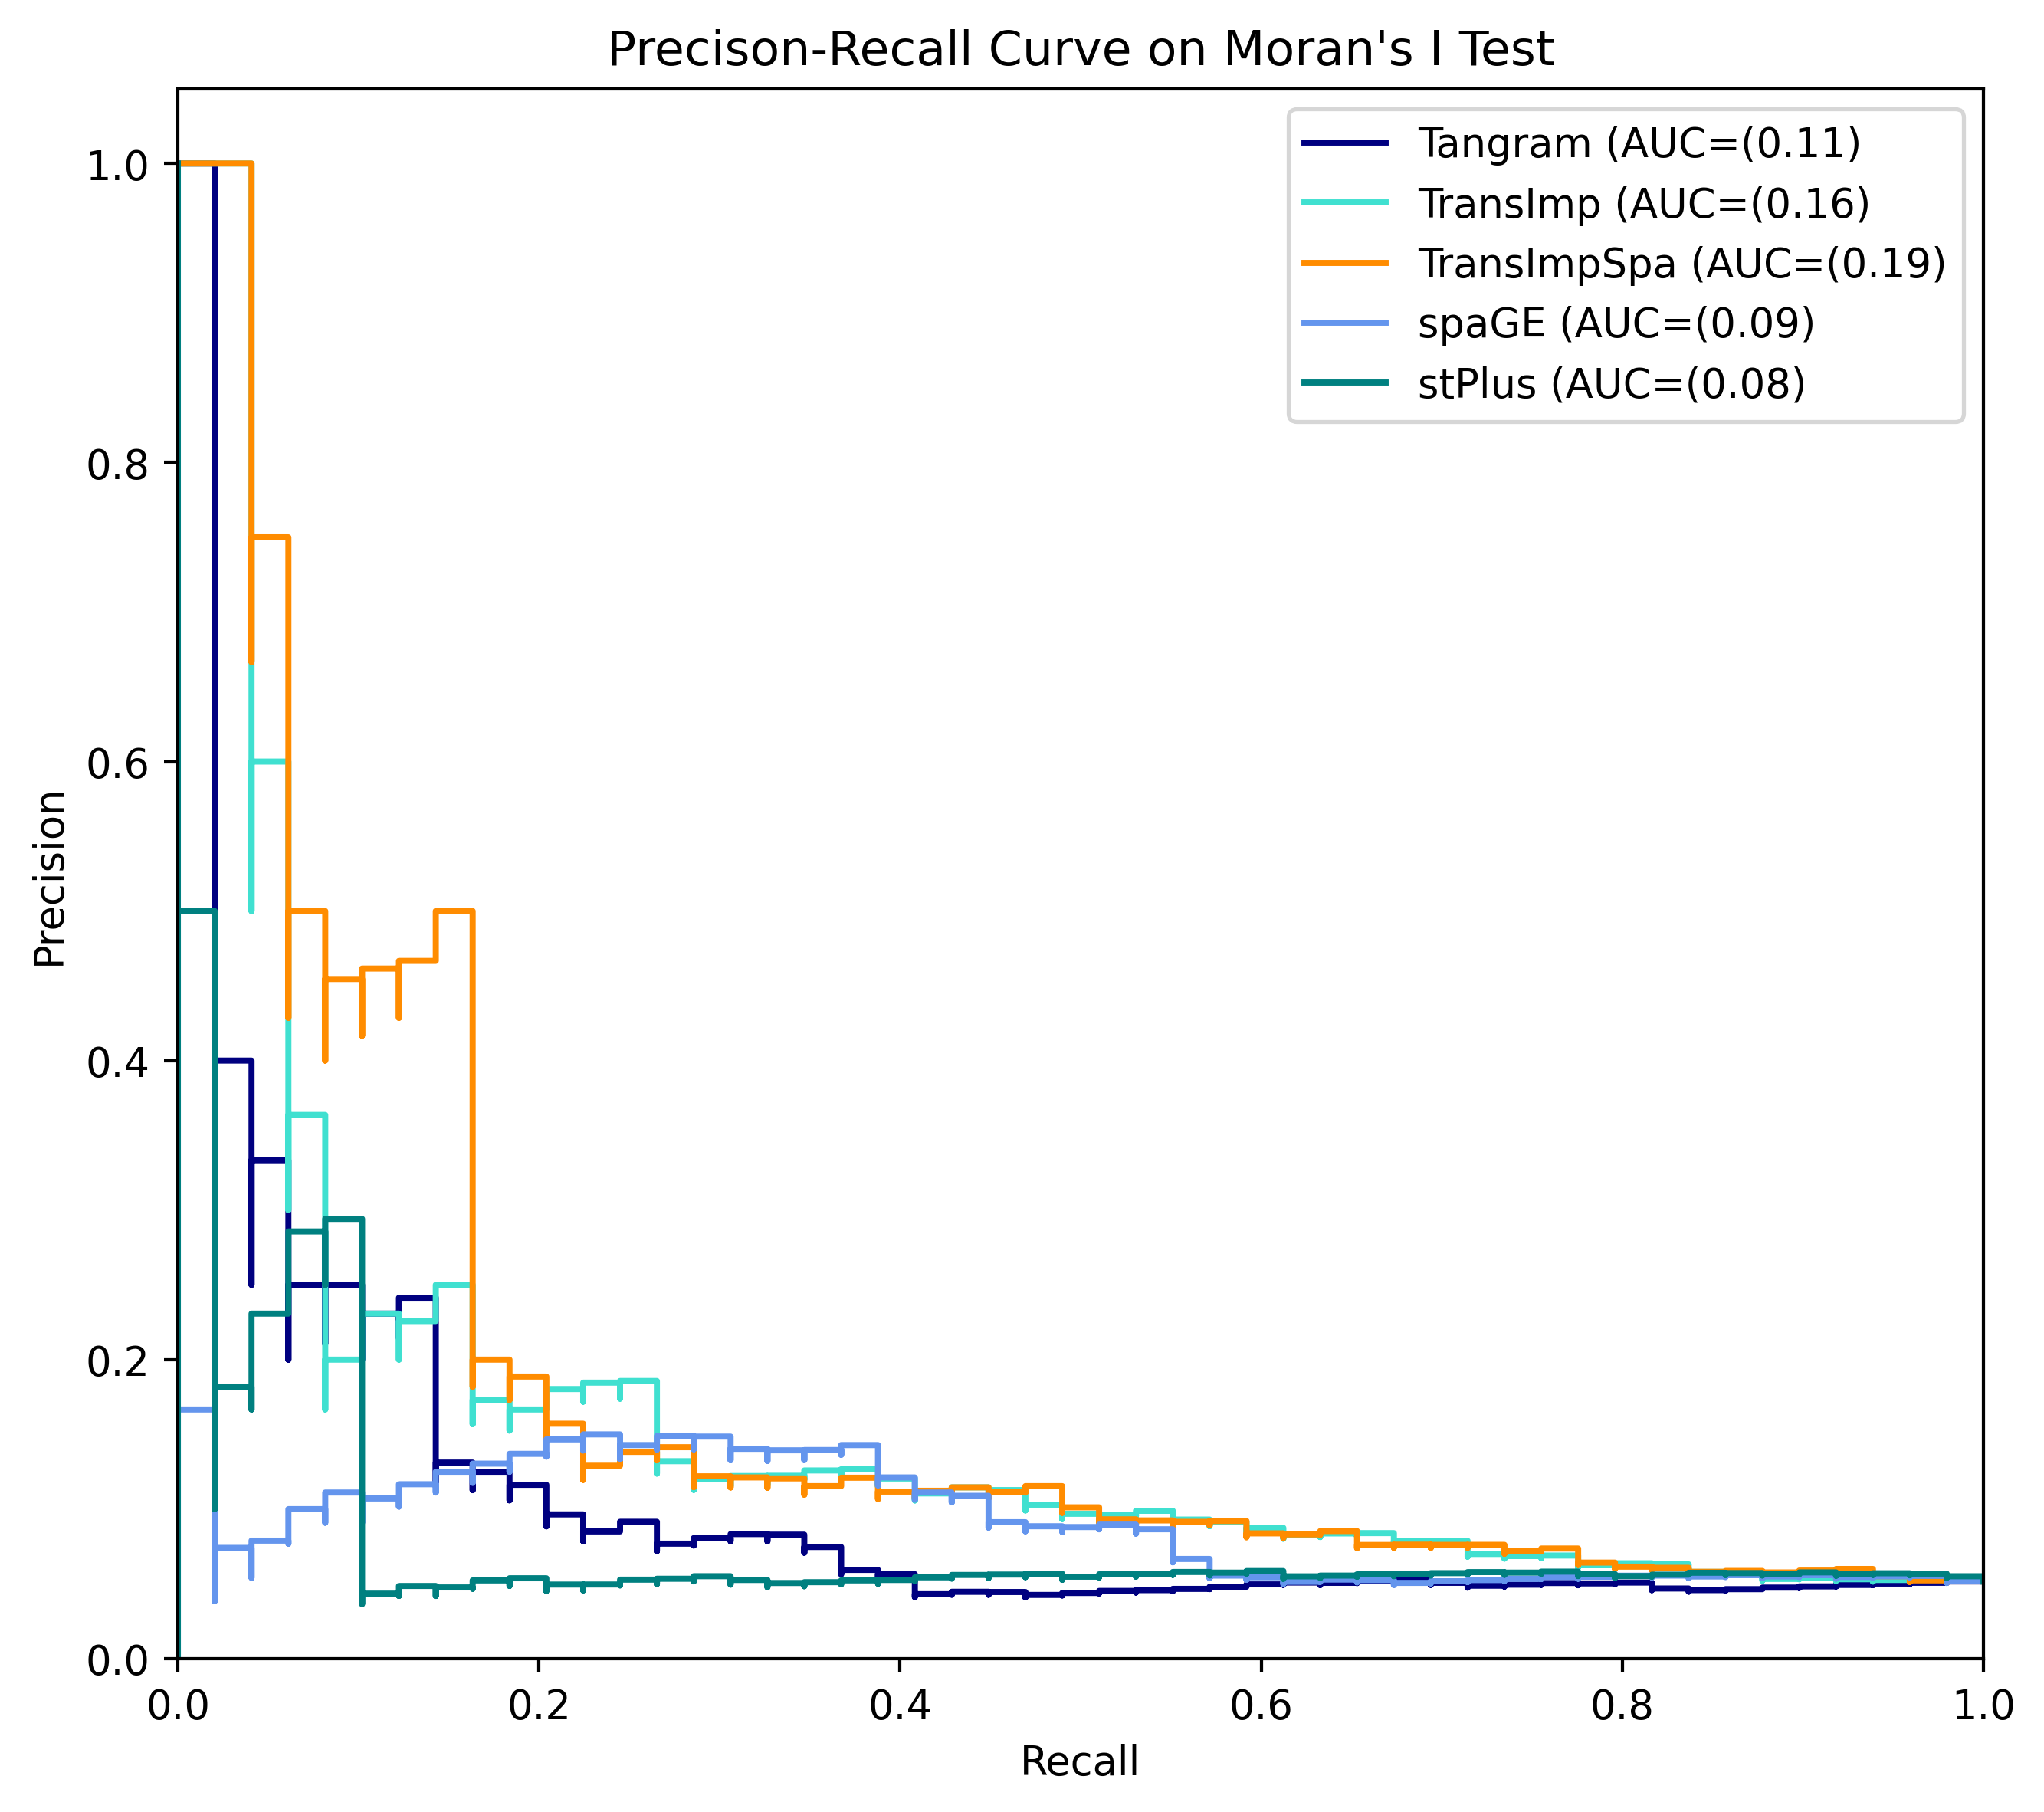

In [16]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred

    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(y < thred, I):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 949/2726
Tangram
FPR: 0.861111
(TransImp) Valid genes: 949/2726
TransImp
FPR: 0.483333
(TransImpSpa) Valid genes: 949/2726
TransImpSpa
FPR: 0.468889
(spaGE) Valid genes: 949/2726
spaGE
FPR: 0.415556
(stPlus) Valid genes: 949/2726
stPlus
FPR: 0.511111


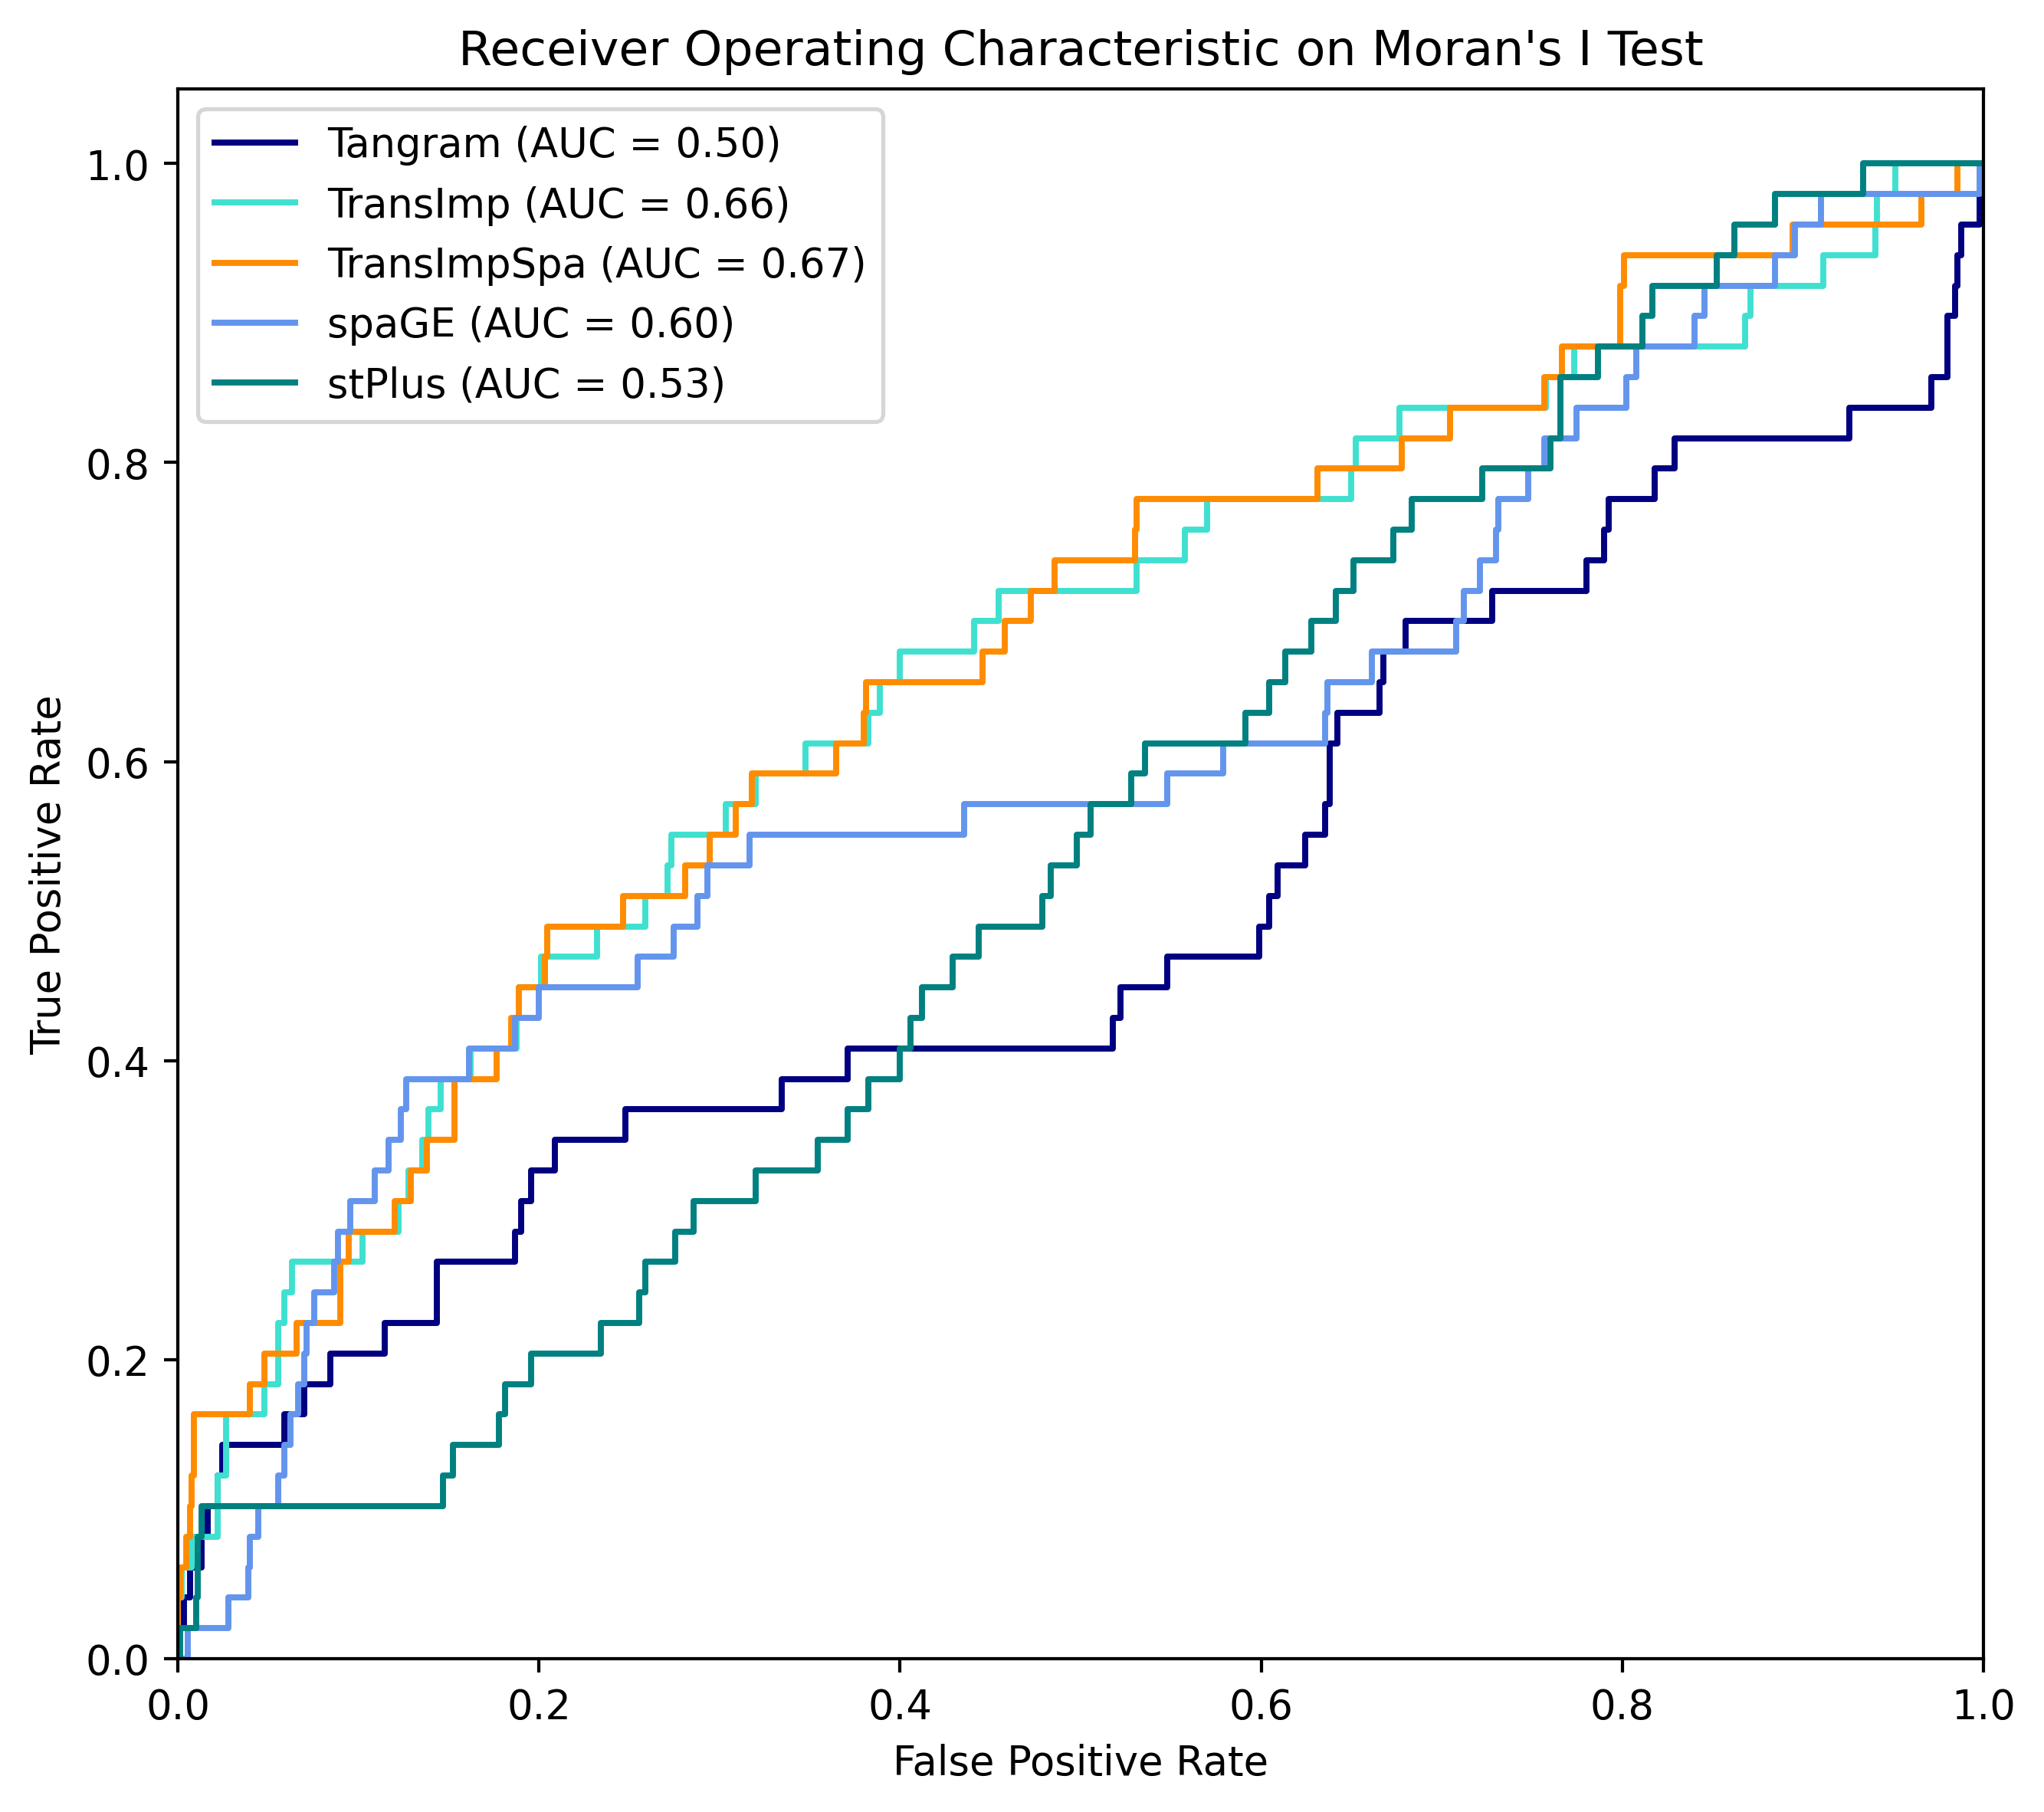

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [17]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(y < thred, I):.2f})", color=color[idx])
    


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 949/2726
Tangram
FPR: 0.861111
prec: 0.05602923264311815, recl: 0.9387755102040817,  F1: 0.10574712643678161
(TransImp) Valid genes: 949/2726
TransImp
FPR: 0.483333
prec: 0.05434782608695652, recl: 0.5102040816326531,  F1: 0.09823182711198428
(TransImpCls) Valid genes: 949/2726
TransImpCls
FPR: 0.771111
prec: 0.055782312925170066, recl: 0.8367346938775511,  F1: 0.10459183673469387
(TransImpClsSpa) Valid genes: 949/2726
TransImpClsSpa
FPR: 0.332222
prec: 0.05379746835443038, recl: 0.3469387755102041,  F1: 0.09315068493150686
(TransImpSpa) Valid genes: 949/2726
TransImpSpa
FPR: 0.468889
prec: 0.053811659192825115, recl: 0.4897959183673469,  F1: 0.09696969696969696
(spaGE) Valid genes: 949/2726
spaGE
FPR: 0.415556
prec: 0.053164556962025315, recl: 0.42857142857142855,  F1: 0.09459459459459459
(stPlus) Valid genes: 949/2726
stPlus
FPR: 0.511111
prec: 0.055441478439425054, recl: 0.5510204081632653,  F1: 0.10074626865671642


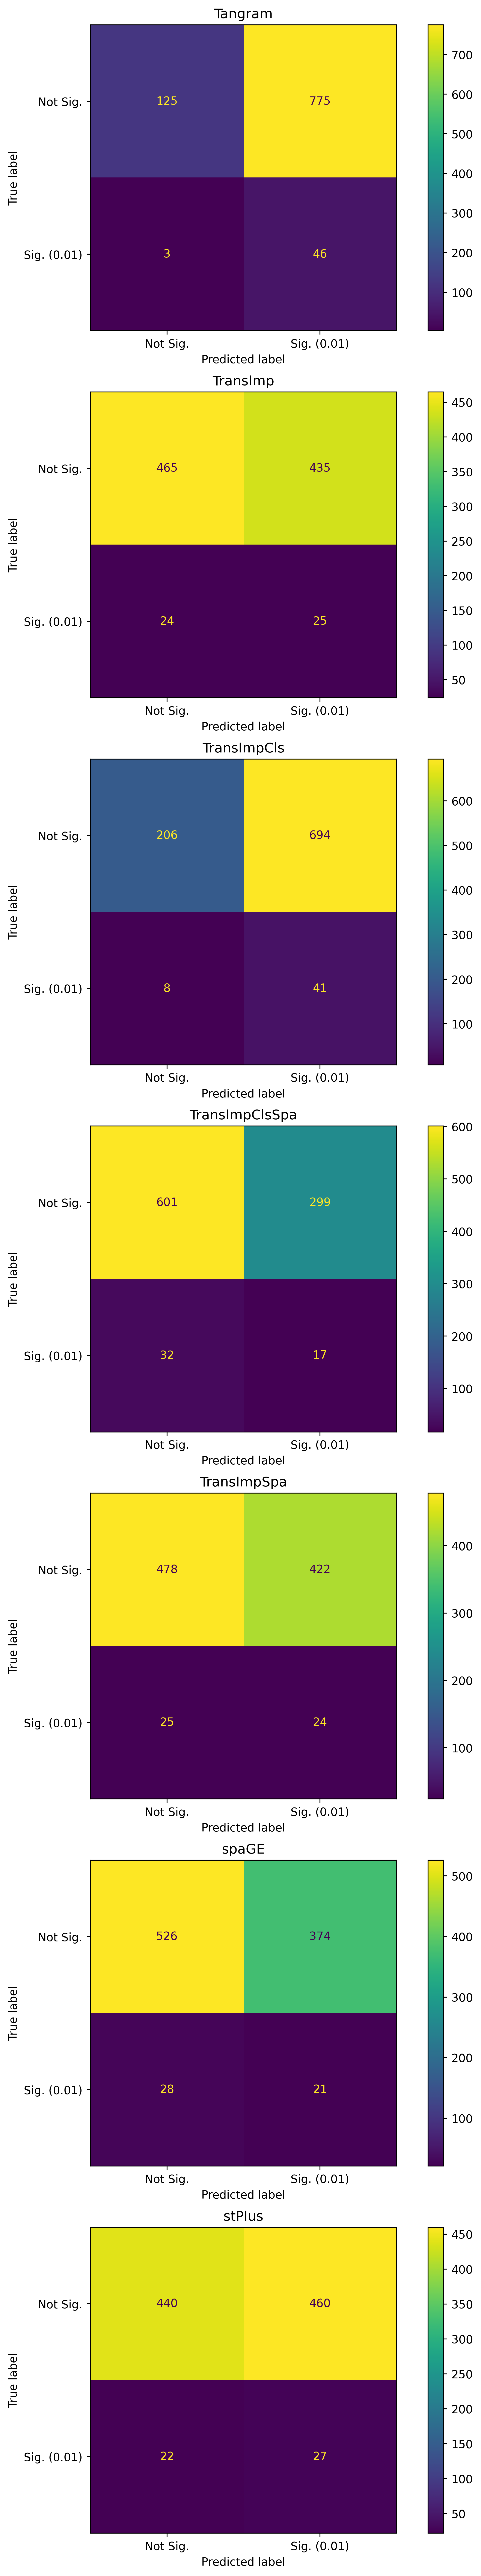

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

## SparkX

In [19]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r melanoma

[1] "transImpute"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 2726 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "transImpSpa"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 2726 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## T

In [20]:
methods = ["transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus", "Tangram", "truth"]
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None
name_mapping = {"transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
for md in methods:
    df = pd.read_csv(f"../../output/sparkx_melanoma_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    if md in name_mapping:
        md = name_mapping[md]
        
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

(            TransImp   TransImpSpa   TransImpCls  TransImpClsSpa     spaGE  \
 AACS    1.982256e-01  8.590869e-02  6.087310e-03    3.559685e-02  0.004707   
 AAED1   5.410494e-01  5.135893e-02  3.392719e-05    7.459026e-04  0.000077   
 ABCA10  1.982655e-02  8.229140e-02  1.458720e-02    2.132770e-01  0.240056   
 ABCA8   1.230708e-01  7.063672e-03  2.412864e-02    1.042565e-01  0.010047   
 ABCB4   6.229239e-12  1.218537e-08  1.330078e-09    1.404372e-07  0.000239   
 ...              ...           ...           ...             ...       ...   
 ZUFSP   1.348052e-02  1.466357e-02  2.227727e-02    8.293460e-02  0.467267   
 ZW10    1.071041e-01  1.345251e-01  1.384324e-02    8.244374e-02  0.015734   
 ZWILCH  4.937158e-01  1.642901e-01  2.408319e-02    1.270508e-01  0.012418   
 ZWINT   5.334666e-05  5.372401e-06  3.737572e-07    1.195415e-04  0.000020   
 ZXDA    2.356496e-01  6.558424e-02  3.401876e-01    4.062310e-01  0.263390   
 
               stPlus       Tangram     truth  
 A

(Tangram) Valid genes: 2726/2726
Tangram
FPR: 0.536900
(TransImp) Valid genes: 2726/2726
TransImp
FPR: 0.228782
(TransImpSpa) Valid genes: 2726/2726
TransImpSpa
FPR: 0.197417
(spaGE) Valid genes: 2726/2726
spaGE
FPR: 0.140590
(stPlus) Valid genes: 2726/2726
stPlus
FPR: 0.339483


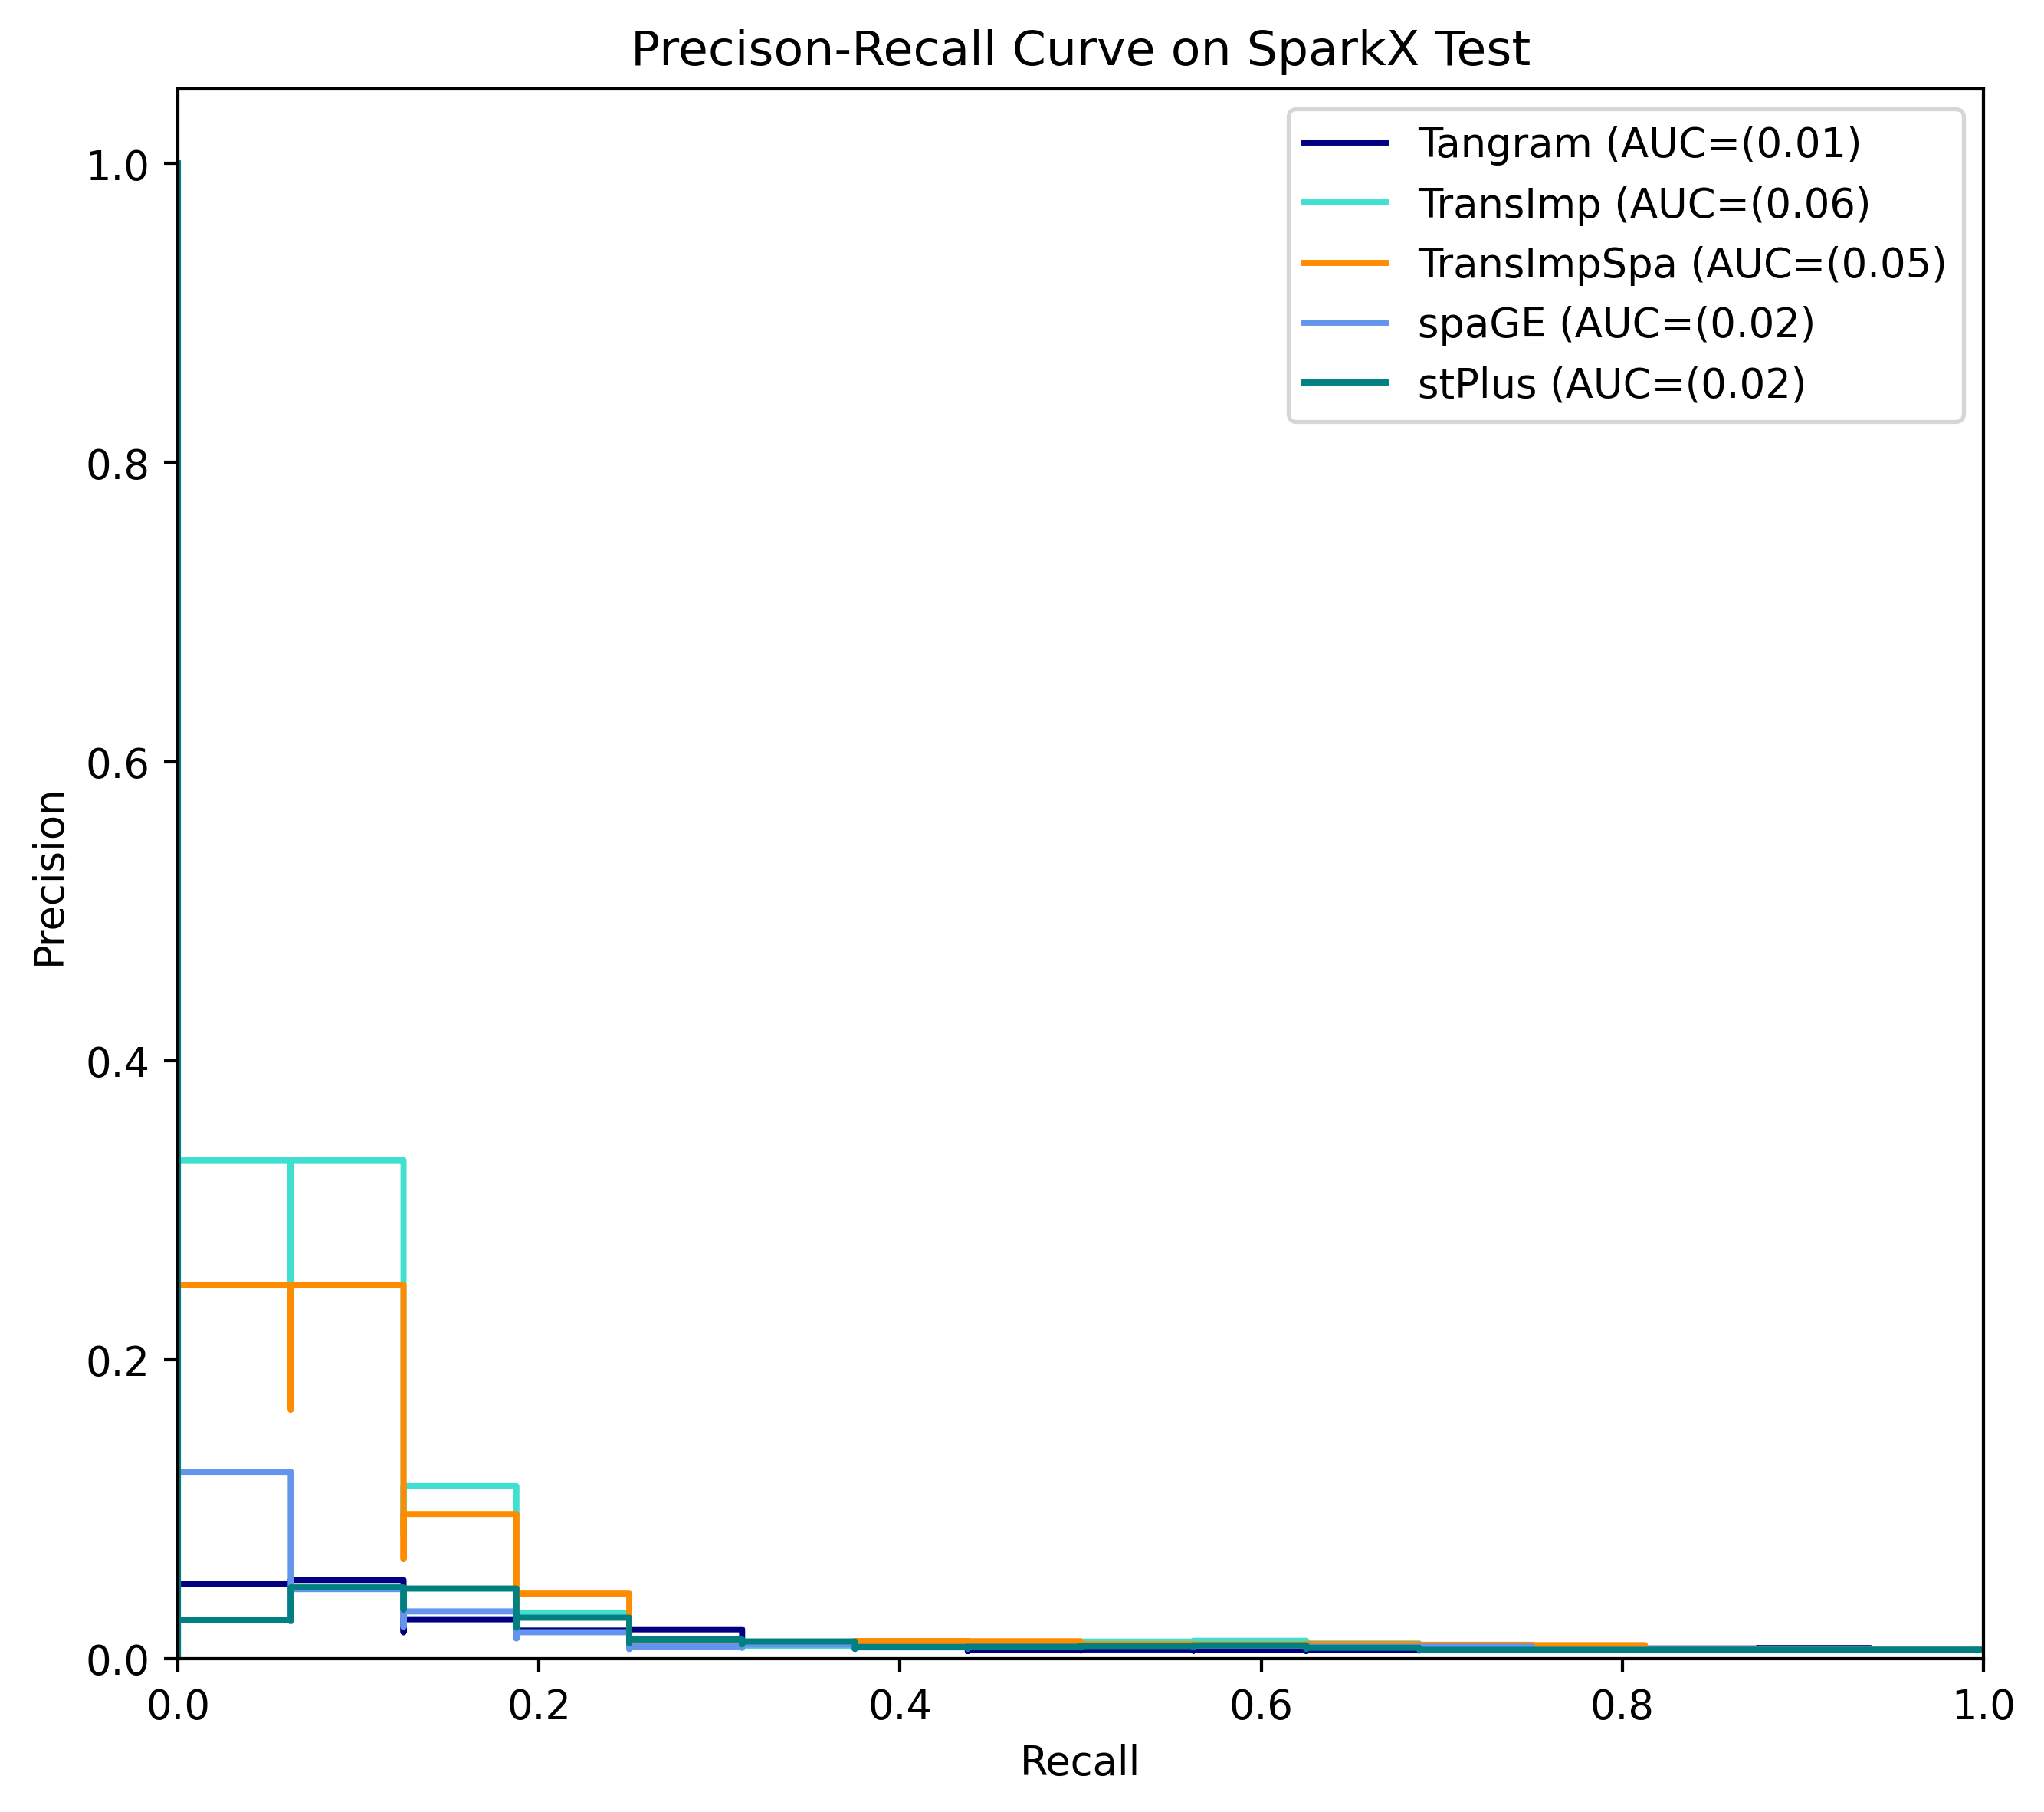

In [21]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    # score = 1 - df_sparkx_cmbpvals[method][sel].values
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 2726/2726
Tangram
FPR: 0.536900
(TransImp) Valid genes: 2726/2726
TransImp
FPR: 0.228782
(TransImpSpa) Valid genes: 2726/2726
TransImpSpa
FPR: 0.197417
(spaGE) Valid genes: 2726/2726
spaGE
FPR: 0.140590
(stPlus) Valid genes: 2726/2726
stPlus
FPR: 0.339483


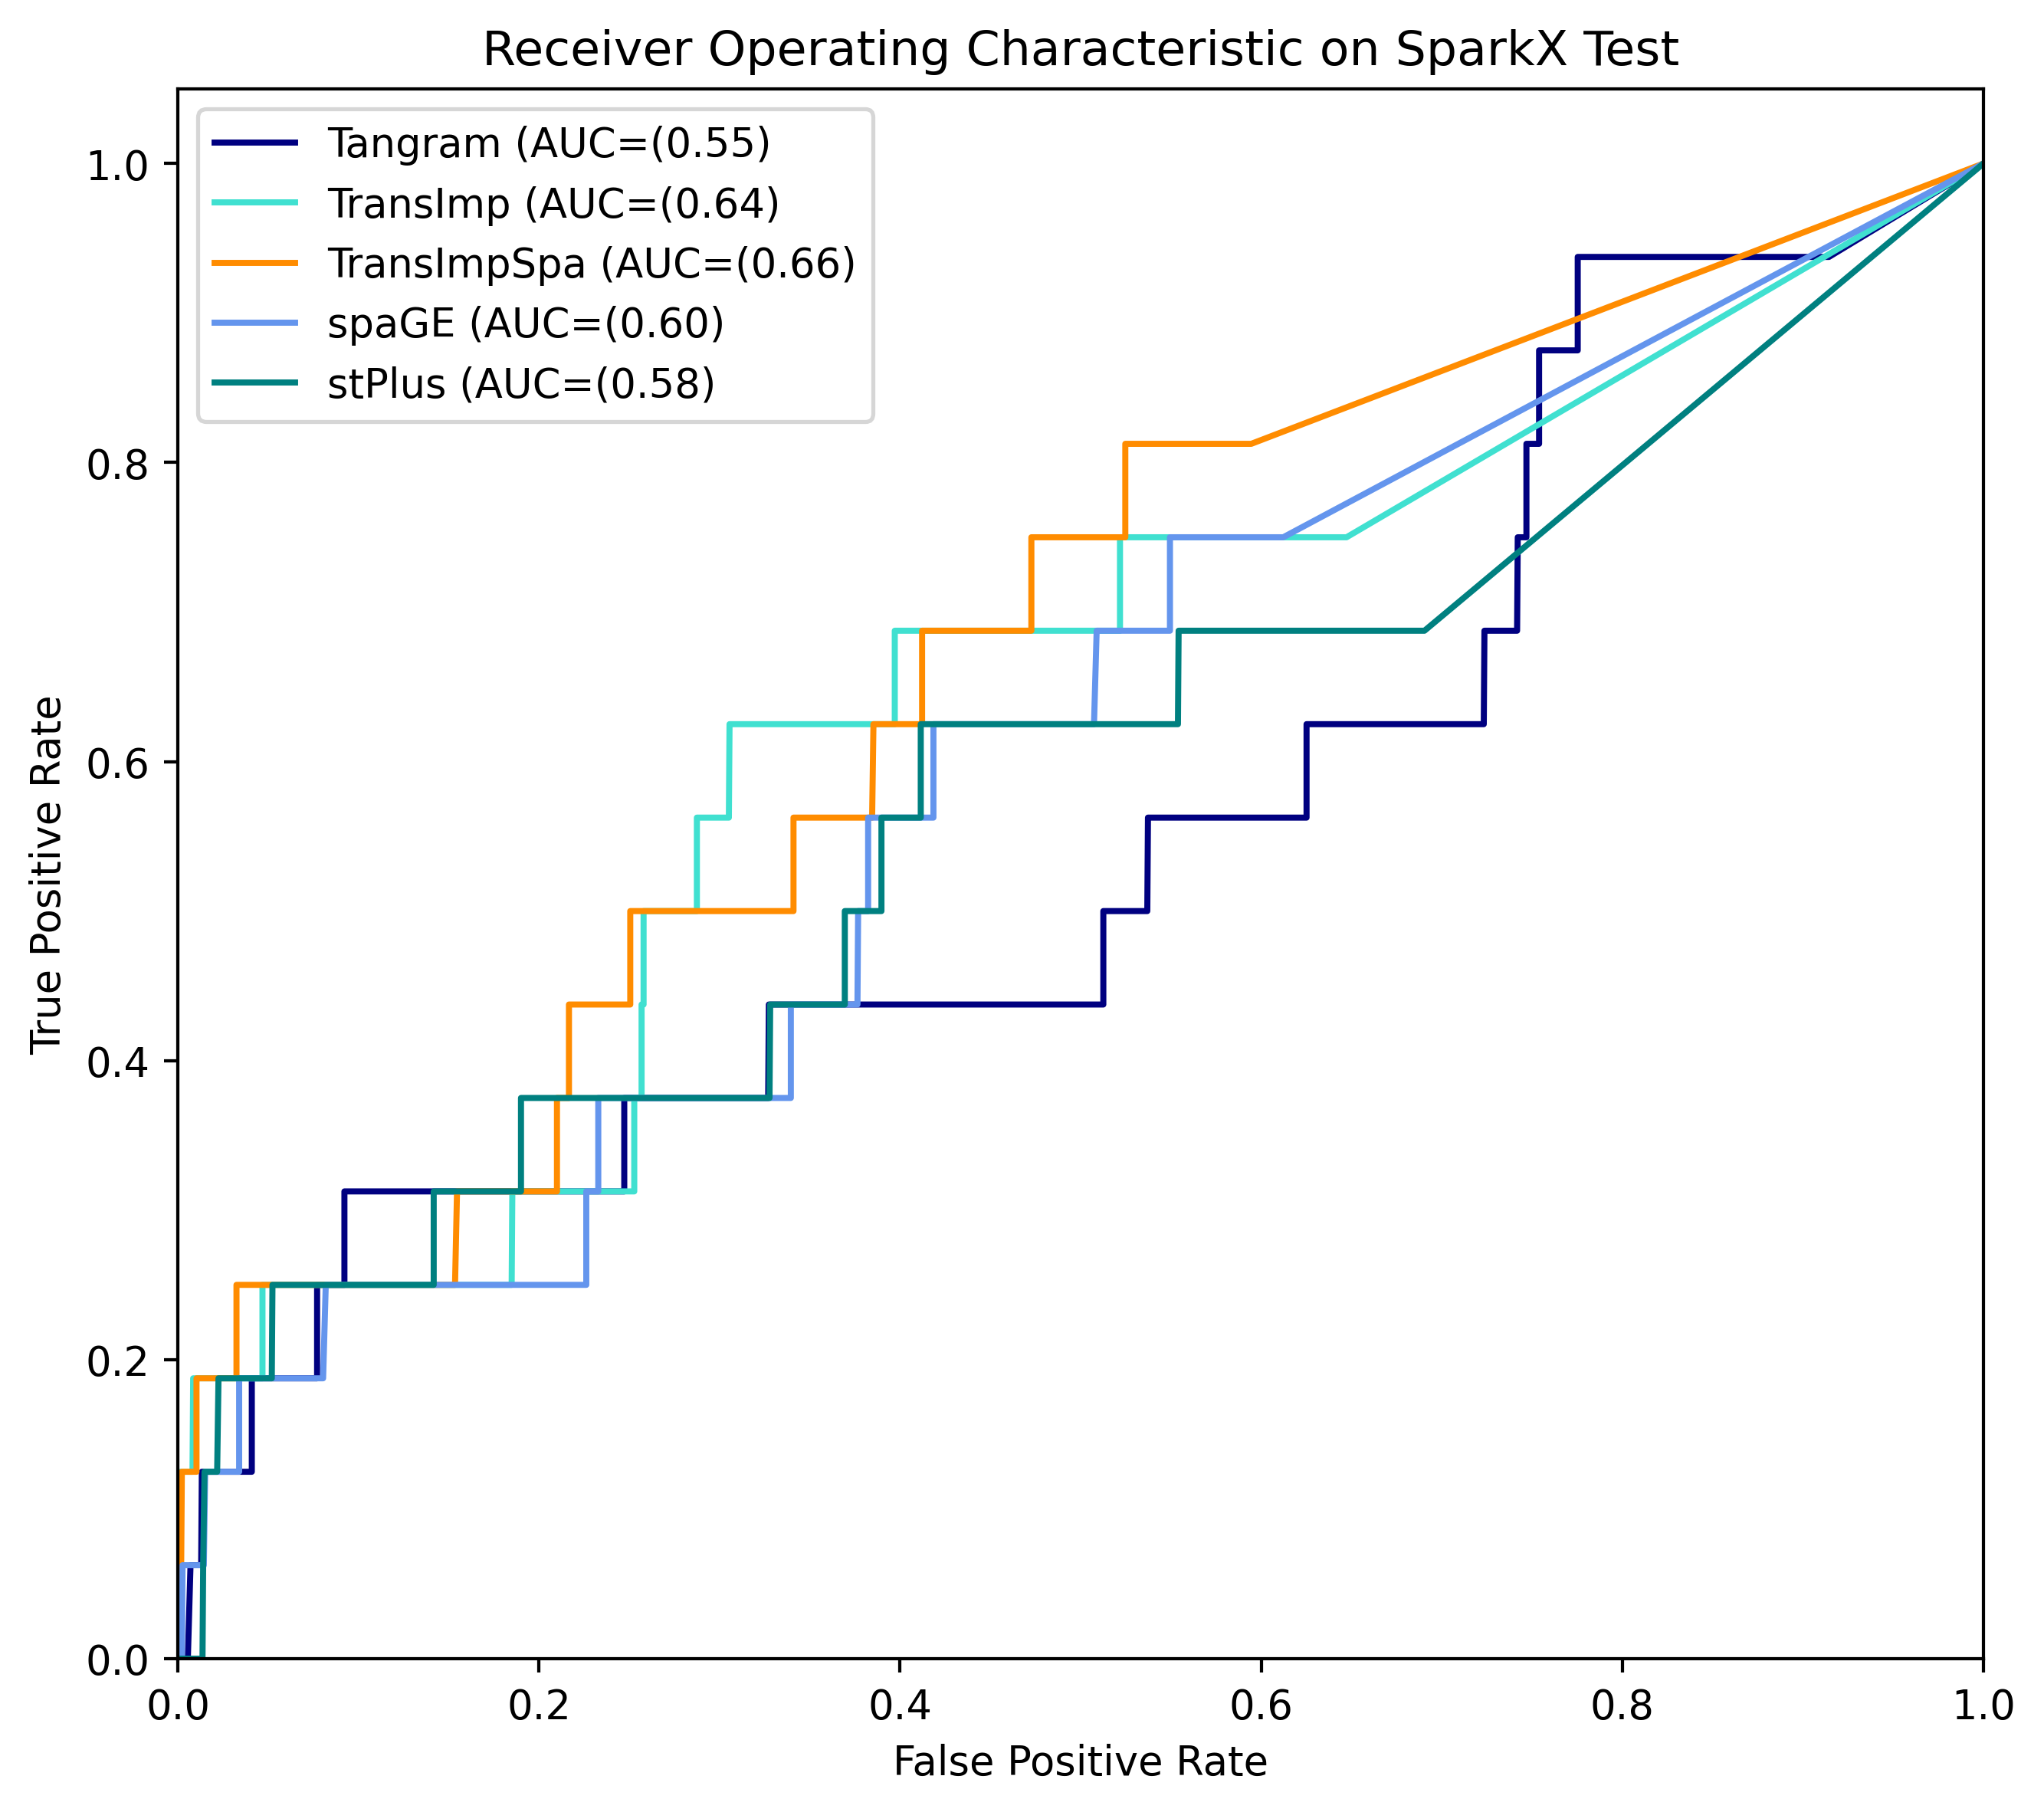

In [22]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 2726/2726
Tangram
FPR: 0.536900
prec: 0.005468215994531784, recl: 0.5,  F1: 0.010818120351588913
(TransImp) Valid genes: 2726/2726
TransImp
FPR: 0.228782
prec: 0.008, recl: 0.3125,  F1: 0.015600624024960999
(TransImpCls) Valid genes: 2726/2726
TransImpCls
FPR: 0.366790
prec: 0.007984031936127744, recl: 0.5,  F1: 0.015717092337917484
(TransImpClsSpa) Valid genes: 2726/2726
TransImpClsSpa
FPR: 0.204059
prec: 0.008960573476702509, recl: 0.3125,  F1: 0.01742160278745645
(TransImpSpa) Valid genes: 2726/2726
TransImpSpa
FPR: 0.197417
prec: 0.009259259259259259, recl: 0.3125,  F1: 0.017985611510791366
(spaGE) Valid genes: 2726/2726
spaGE
FPR: 0.140590
prec: 0.01038961038961039, recl: 0.25,  F1: 0.0199501246882793
(stPlus) Valid genes: 2726/2726
stPlus
FPR: 0.339483
prec: 0.007551240560949299, recl: 0.4375,  F1: 0.014846235418875928


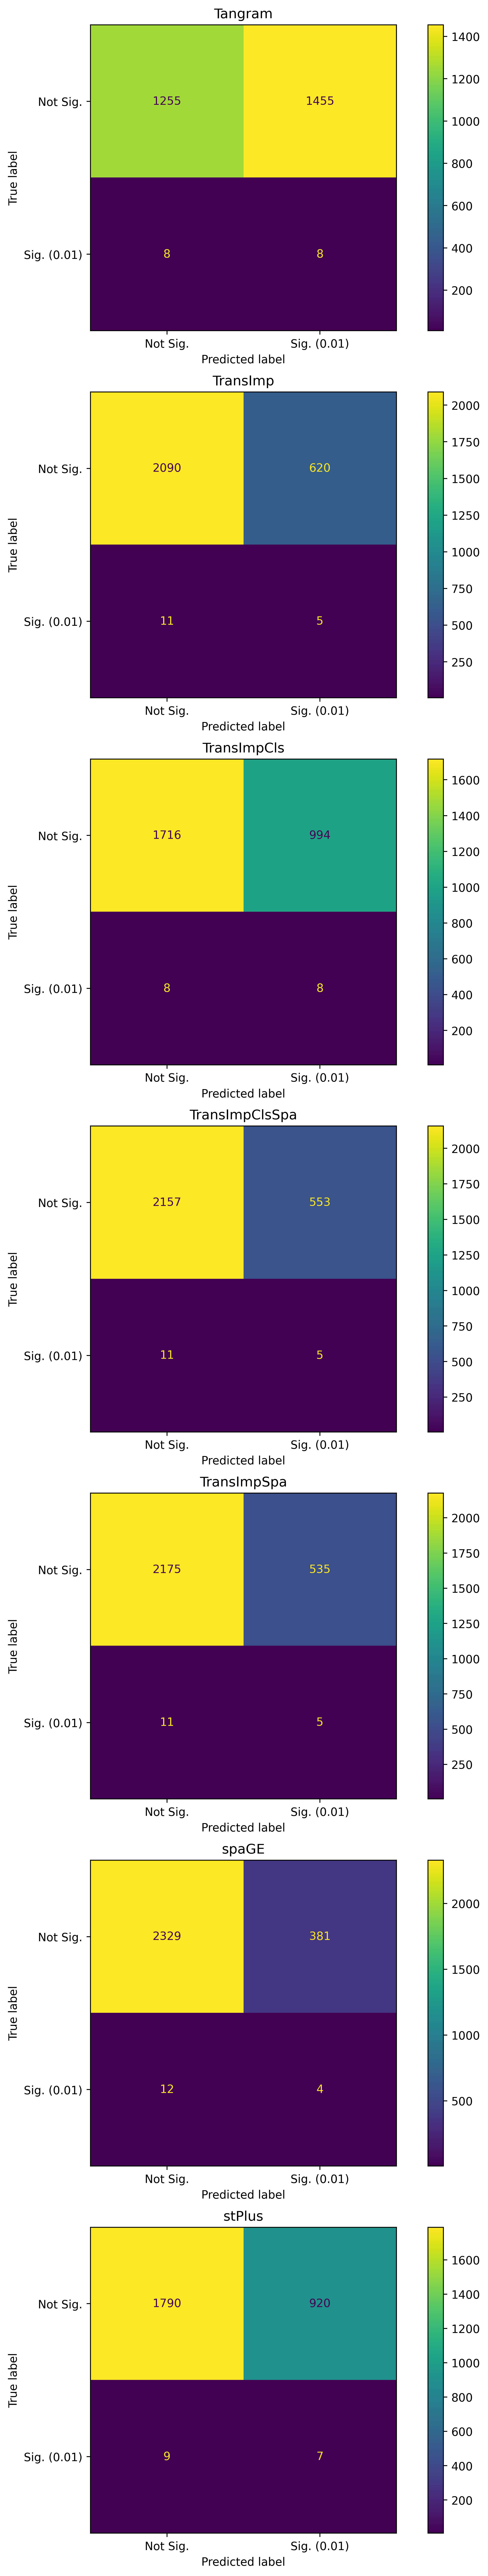

In [23]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()